In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from IPython.display import clear_output
sns.set()

def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

#### If you are using Google Colab you fill need following two lines of code

In [2]:
from google.colab import drive
drive.mount('/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive/


# Loading data

Data is stored in `.npz`-format which is a special filetype for persisting multiple NumPy arrays on disk. 

More info: https://docs.scipy.org/doc/numpy/reference/generated/numpy.lib.format.html#module-numpy.lib.format.

File `dat_train.npz` contains four arrays: 

  * `EnergyDeposit` - images of calorimeters responses
  * `ParticleMomentum` - $p_x, p_y, p_z$ of initial partice
  * `ParticlePoint` - $x, y$ of initial particle
  * `ParticlePDG` - particle type(either $e^-$ or $\gamma$)

In [3]:
# open train dataset
data_real = np.load('/gdrive/My Drive/mlhep2019/data_train.npz', allow_pickle=True)
print(list(data_real.keys()))

# [data_size, 900]
EnergyDeposit = data_real['EnergyDeposit']
# reshaping it as [data_size, img_size_x, img_size_y]
EnergyDeposit = EnergyDeposit.reshape(-1, 30, 30)

# [data_size, 3]
ParticleMomentum = data_real['ParticleMomentum']

# [data_size, 2]
ParticlePoint = data_real['ParticlePoint']

# [data_size, 1]
ParticlePDG = data_real['ParticlePDG']

['EnergyDeposit', 'ParticlePoint', 'ParticleMomentum', 'ParticlePDG']


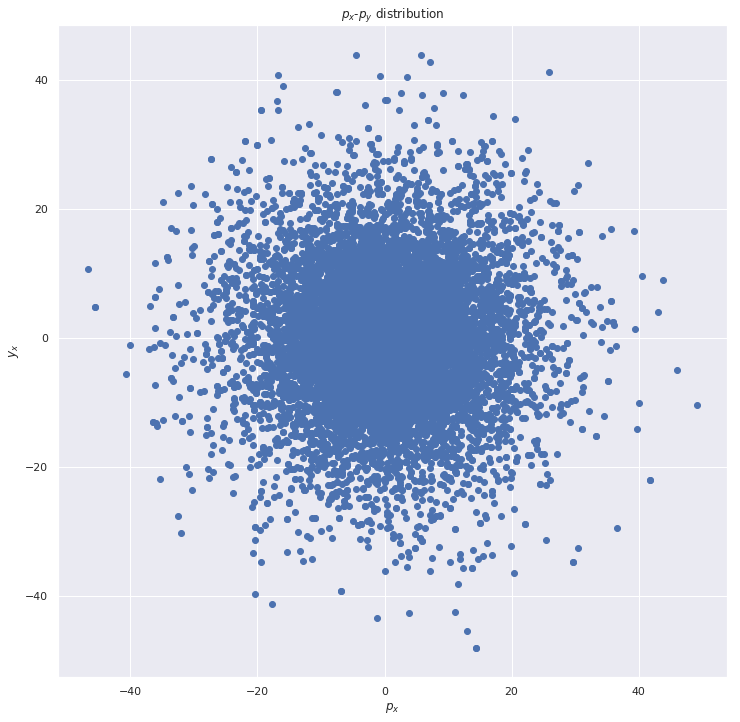

In [4]:
plt.figure(figsize=(12, 12))
plt.title('$p_x$-$p_y$ distribution')
plt.scatter(ParticleMomentum[:, 0], ParticleMomentum[:, 1]);
plt.xlabel('$p_x$')
plt.ylabel('$y_x$')
plt.show()

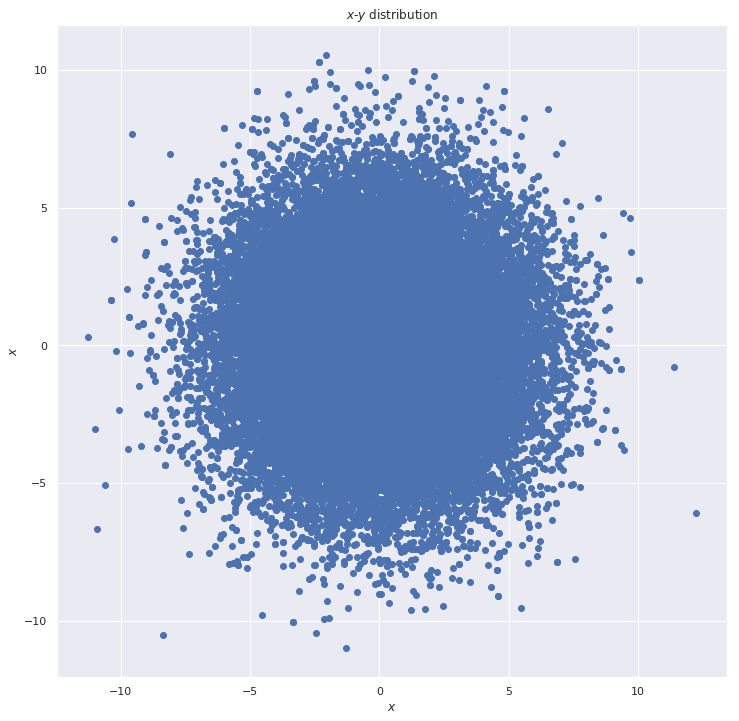

In [5]:
plt.figure(figsize=(12, 12))
plt.title('$x$-$y$ distribution')
plt.scatter(ParticlePoint[:, 0], ParticlePoint[:, 1]);
plt.xlabel('$x$')
plt.ylabel('$x$')
plt.show()

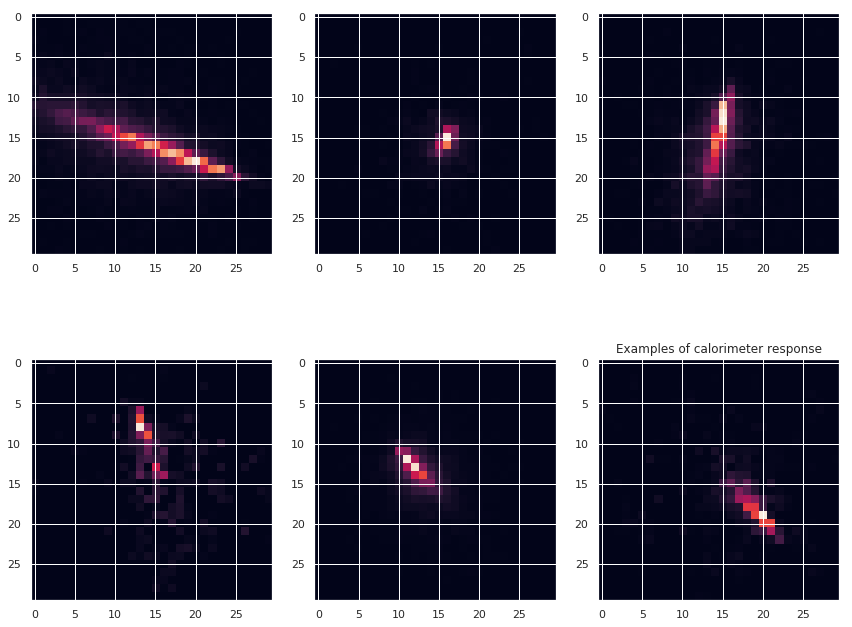

In [6]:
f, axs = plt.subplots(2, 3, figsize=(12, 10))

for i in range(6):
    axs[i // 3][i % 3].imshow(EnergyDeposit[i])
plt.title('Examples of calorimeter response')
plt.tight_layout()
plt.show()

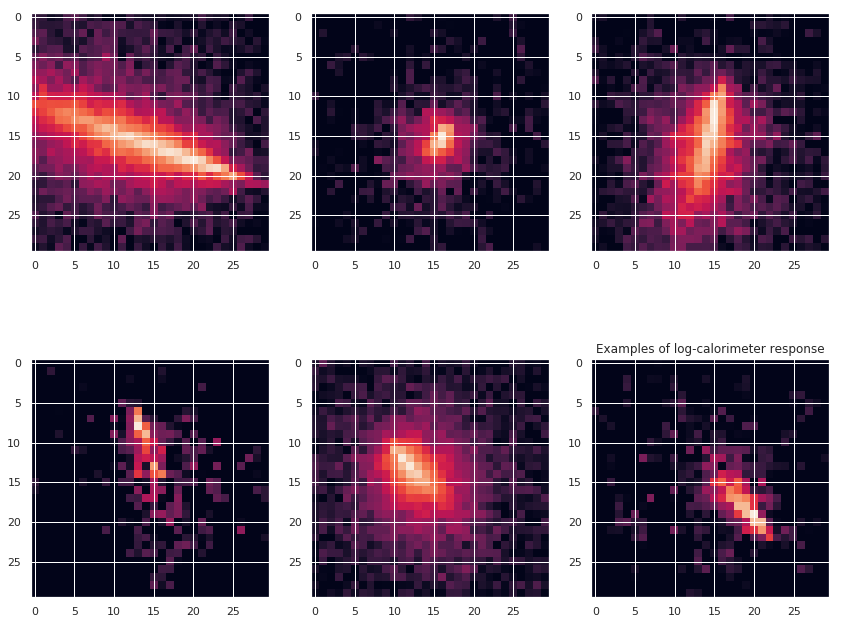

In [9]:
f, axs = plt.subplots(2, 3, figsize=(12, 10))

for i in range(6):
    axs[i // 3][i % 3].imshow(np.log(1 + EnergyDeposit[i]))
plt.title('Examples of log-calorimeter response')
plt.tight_layout()
plt.show()

In [0]:
# not actully interested in p_z momentum
ParticleMomentum = ParticleMomentum[:, :2]
ParticlePoint = ParticlePoint[:, :2]

ParticleMomentum_ParticlePoint = np.concatenate([ParticleMomentum, ParticlePoint], axis=1)

## Solving it with some simple image processing

In [0]:
# !pip install scikit-image

In [0]:
from skimage import measure
from sklearn.preprocessing import PolynomialFeatures
polynomial_features = PolynomialFeatures(degree=2)

## Images moments

Raw moments:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/cd837e91c341939056d1f48c66a4d46170f59af0)

Central moments:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/ce558736e1d184612633ab799a8d1eb019cc2fba)

In [0]:
ORDER_OF_MOMENT = 2

In [14]:
# our feature matrix
X = []
for img in tqdm(EnergyDeposit):
    X.append(np.concatenate([measure.moments(img, order=ORDER_OF_MOMENT).ravel(), 
                             measure.moments_central(img, order=ORDER_OF_MOMENT).ravel()]))

# concat everything together
X = np.c_[X]

100%|██████████| 50250/50250 [00:06<00:00, 7658.17it/s]


In [0]:
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X = (X - X_mean) / X_std
X = polynomial_features.fit_transform(X)

# idx_of_features = [17, 35, 52, 68, 83, 97, 110, 122, 133, 143]
# X = X[:, idx_of_features]

In [0]:
"""
for i in range(X.shape[1]):
    print(i)
    plt.figure()
    plt.scatter(X[:, i], ParticleMomentum[:, 0])
    plt.show()
"""

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import TheilSenRegressor

model = LinearRegression().fit(X, ParticleMomentum_ParticlePoint)

## Make predictions for validation set

In `data_val.npz` and `data_test.npz` you only have one key: `EnergyDeposit`.

In [0]:
# load validation data
data_val = 'np.load/gdrive/My Drive/mlhep2019/data_val.npz', allow_pickle=True)
EnergyDeposit_val = data_val['EnergyDeposit']
EnergyDeposit_val = EnergyDeposit_val.reshape(-1, 30, 30)

In [0]:
# our feature matrix
X_val = []
for img in tqdm(EnergyDeposit_val):
    X_val.append(np.concatenate([measure.moments(img, order=ORDER_OF_MOMENT).ravel(), 
                                 measure.moments_central(img, order=ORDER_OF_MOMENT).ravel()]))
X_val = np.c_[X_val]
X_val = (X_val - X_mean) / X_std
X_val = polynomial_features.transform(X_val)
# X_val = X_val[:, idx_of_features]

In [0]:
# predicting [data_num, 4] array with px, py, x, y
prediction_val = model.predict(X_val)

In [0]:
# splitting ParticleMomentum and ParticlePoint in two arrays
ParticleMomentum_val, ParticlePoint_val = prediction_val[:, :2], prediction_val[:, 2:]

In [0]:
# saving predictions in .npz format
np.savez_compressed('data_val_prediction.npz', 
                    ParticlePoint=ParticlePoint_val, 
                    ParticleMomentum=ParticleMomentum_val)

## Make predictions for test set

In [0]:
# loading test dataset
data_test = np.load('/gdrive/My Drive/mlhep2019/data_test.npz', allow_pickle=True)
EnergyDeposit_test = data_test['EnergyDeposit']
EnergyDeposit_test = EnergyDeposit_test.reshape(-1, 30, 30)

In [0]:
# our feature matrix
X_test = []
for img in tqdm(EnergyDeposit_test):
    X_test.append(np.concatenate([measure.moments(img, order=ORDER_OF_MOMENT).ravel(), 
                                  measure.moments_central(img, order=ORDER_OF_MOMENT).ravel()]))
X_test = np.c_[X_test]
X_test = (X_test - X_mean) / X_std
X_test = polynomial_features.transform(X_test)
# X_test = X_test[:, idx_of_features]

In [0]:
# predicting [data_num, 4] array with px, py, x, y
prediction_test = model.predict(X_test)

In [0]:
# splitting ParticleMomentum and ParticlePoint in two arrays
ParticleMomentum_test, ParticlePoint_test = prediction_test[:, :2], prediction_test[:, 2:]

In [0]:
# saving predictions in .npz format
np.savez_compressed('data_test_prediction.npz', 
                    ParticlePoint=ParticlePoint_test, 
                    ParticleMomentum=ParticleMomentum_test)

In [0]:
plt.scatter(*ParticleMomentum_test.T);

In [0]:
plt.scatter(*ParticlePoint_test.T);

## `zip-zip` files together

In [0]:
!zip solution.zip data_val_prediction.npz data_test_prediction.npz

In [0]:
from IPython.display import FileLink
FileLink('./solution.zip')

## Awesome, you are breathtaking!

![](https://i.kym-cdn.com/entries/icons/original/000/030/029/cover2.jpg)

Now you can send it to codalab :)

If you forgot where it is: http://codalab.coresearch.club/competitions/70

## Future steps:

1. try different linear models: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
2. parameter optimiation: L1/L2-regularization parameters, etc.
3. calculater higher order polynomial features
4. apply some feature selections procedures
5. data augmentation: rotate & shift images(do not forget to transform $p_x, p_y$, $x, y$ as well!)